In [1]:
!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.datasets import cifar100
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, UpSampling2D, Dropout, BatchNormalization, RandomFlip, RandomTranslation, RandomRotation,RandomBrightness, RandomContrast, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import re

2024-04-09 15:21:06.607774: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 15:21:06.698612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 15:21:07.890925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
n_epoch = 100
batch_size = 100
taux_validation = 0.1
num_classes = 100
n_images = 50000 # Pour l'entrainement, et 10000 pour le test

In [3]:
def preprocessing(image, label):
    image = tf.image.resize(image, (224, 224))
    label = tf.squeeze(tf.one_hot(label, depth = num_classes), axis = 0)
    return  image, label

augmentation_donnees_keras = Sequential([
    RandomFlip("horizontal"),
    RandomTranslation(0.2,0.2),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2,value_range=(0,1))
])

def augmentation_donnees(image, label):
    return augmentation_donnees_keras(image/255.0, training = True)*255.0, label

def preprocess_resnet(image, label):
    return preprocess_input(image), label

train_dataset, test_dataset = cifar100.load_data()

validation_size = int(n_images * taux_validation)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).map(preprocessing).shuffle(n_images, reshuffle_each_iteration=False)
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset).map(preprocessing)

validation_dataset = train_dataset.take(validation_size).cache().batch(batch_size).map(preprocess_resnet).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.skip(validation_size).cache().batch(batch_size).map(augmentation_donnees,num_parallel_calls=tf.data.AUTOTUNE).map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).map(preprocess_resnet, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

2024-04-09 15:21:08.903911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12041 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6


In [4]:
model = Sequential([
    ResNet50V2(include_top=False, weights='imagenet', pooling="avg"),
    Dropout(0.25),
    Dense(256, activation="sigmoid", kernel_regularizer = tf.keras.regularizers.L1(0.001)),
    Dropout(0.5),
    Dense(num_classes, activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.001))
])

In [5]:
!mkdir -p sauvegardes
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
csv_logger = CSVLogger("sauvegardes/modele_enseignant_logs.csv", separator=",", append=False)
model_checkpoint_callback = ModelCheckpoint(filepath="sauvegardes/modele_enseignant_checkpoint.keras", monitor='val_loss', save_best_only=True)

for layer in model.layers:
    if layer.name == "resnet50v2":
        for layer in layer.layers[:]:
          if (re.match("^.*(_3_conv|_bn)$", layer.name)):
            layer.trainable = True
          else:
            layer.trainable = False

model.fit(train_dataset, epochs=n_epoch, batch_size=batch_size, validation_data = validation_dataset, callbacks = [early_stopping_callback, csv_logger, model_checkpoint_callback])

Epoch 1/100


I0000 00:00:1712676100.386500  112418 service.cc:145] XLA service 0x7f2fc40022e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712676100.386556  112418 service.cc:153]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2024-04-09 15:21:41.425726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-09 15:21:59.620509: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900
I0000 00:00:1712676127.737528  112630 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_15283', 108 bytes spill stores, 108 bytes spill loads

I0000 00:00:1712676128.024296  112622 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_21685', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1712676128

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.1590 - loss: 7.5709

I0000 00:00:1712676438.512738  113068 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1542', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1712676438.868252  113052 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1542', 244 bytes spill stores, 244 bytes spill loads

I0000 00:00:1712676439.097846  113053 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1542', 300 bytes spill stores, 184 bytes spill loads



450/450 ━━━━━━━━━━━━━━━━━━━━ 381s 619ms/step - accuracy: 0.1591 - loss: 7.5655 - val_accuracy: 0.3848 - val_loss: 3.4939
Epoch 2/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 287s 633ms/step - accuracy: 0.3568 - loss: 3.7107 - val_accuracy: 0.5196 - val_loss: 2.9294
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 282s 621ms/step - accuracy: 0.4308 - loss: 3.3829 - val_accuracy: 0.5640 - val_loss: 2.7393
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 282s 621ms/step - accuracy: 0.4709 - loss: 3.1943 - val_accuracy: 0.5934 - val_loss: 2.6291
Epoch 5/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 279s 617ms/step - accuracy: 0.5084 - loss: 3.0462 - val_accuracy: 0.6146 - val_loss: 2.5449
Epoch 6/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 281s 619ms/step - accuracy: 0.5361 - loss: 2.9204 - val_accuracy: 0.6408 - val_loss: 2.4491
Epoch 7/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 283s 625ms/step - accuracy: 0.5598 - loss: 2.8238 - val_accuracy: 0.6506 - val_loss: 2.3693
Epoch 8/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 276s 608ms/step - accuracy: 0.5825 - los

In [6]:
model.save("sauvegardes/modele_enseignant_transfert.keras")

In [7]:
model.evaluate(test_dataset)

100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 249ms/step - accuracy: 0.7417 - loss: 1.8330


[1.830102562904358, 0.7414000034332275]

In [10]:
model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
csv_logger = CSVLogger("sauvegardes/modele_enseignant_logs.csv", separator=",", append=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(filepath="sauvegardes/modele_enseignant_checkpoint.keras", monitor='val_loss', save_best_only=True)
model.fit(train_dataset, epochs=40, batch_size=batch_size, validation_data = validation_dataset, callbacks = [early_stopping_callback, csv_logger, model_checkpoint_callback])

Epoch 1/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 387s 649ms/step - accuracy: 0.8362 - loss: 1.3879 - val_accuracy: 0.7592 - val_loss: 1.5218
Epoch 2/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 289s 636ms/step - accuracy: 0.8384 - loss: 1.2502 - val_accuracy: 0.7594 - val_loss: 1.4644
Epoch 3/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 289s 637ms/step - accuracy: 0.8438 - loss: 1.1960 - val_accuracy: 0.7612 - val_loss: 1.4321
Epoch 4/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 290s 638ms/step - accuracy: 0.8450 - loss: 1.1713 - val_accuracy: 0.7630 - val_loss: 1.4132
Epoch 5/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 284s 625ms/step - accuracy: 0.8509 - loss: 1.1428 - val_accuracy: 0.7614 - val_loss: 1.4005
Epoch 6/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 288s 633ms/step - accuracy: 0.8492 - loss: 1.1444 - val_accuracy: 0.7650 - val_loss: 1.3909
Epoch 7/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 292s 642ms/step - accuracy: 0.8571 - loss: 1.1191 - val_accuracy: 0.7658 - val_loss: 1.3852
Epoch 8/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 296s 652ms/step - accuracy: 0.8563 -

In [11]:
model.save("sauvegardes/modele_enseignant.keras")

In [12]:
model.evaluate(test_dataset)

100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.7644 - loss: 1.3953


[1.3933833837509155, 0.7652999758720398]

In [15]:
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_enseignant.keras s3/afeldmann/projet_cnam/modele_enseignant.keras
!mc cp /home/onyxia/work/projet_distillation_cnam/sauvegardes/modele_enseignant_logs.csv s3/afeldmann/projet_cnam/modele_enseignant_logs.csv

...t_logs.csv: 6.82 KiB / 6.82 KiB ┃▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓┃ 60.91 KiB/s 0s]11;?\

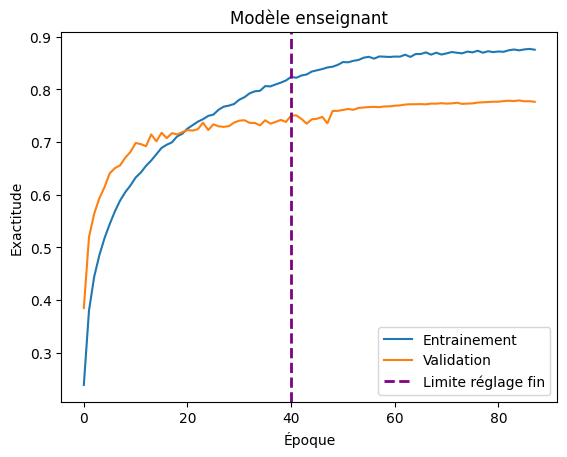

In [30]:
history=np.genfromtxt("sauvegardes/modele_enseignant_logs.csv", delimiter=",", names = True)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Modèle enseignant')
plt.ylabel('Exactitude')
plt.xlabel('Époque')
plt.axvline(x=40, color='purple', ls='--', lw=2, label='Limite réglage fin')
plt.legend(['Entrainement', 'Validation','Limite réglage fin'], loc='best')
plt.show()